<a href="https://colab.research.google.com/github/himanshu-kr-jha/formerPose_implementation/blob/main/FromerPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi -L || true
# !pip -q install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install einops timm open3d transforms3d pyyaml
!pip install torch torchvision -q
!pip install opencv-python scipy gdown matplotlib tqdm -q
print("✅ All packages installed!")

GPU 0: Tesla T4 (UUID: GPU-1b88febb-cfc2-cfba-bfd3-eee06af57758)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00
✅ All packages installed!


In [3]:
import os, cv2, torch, torch.nn as nn
import numpy as np
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import gdown, zipfile
import os, math, random, yaml, time, glob
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, repeat
import transforms3d as t3d
from scipy.spatial import cKDTree
torch.backends.cudnn.benchmark = True

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
import gdown
import zipfile
import os

# Google Drive direct download
file_id = "1hYLuXDbN-zqRhiWxBTGnnjEQsUgRQ4Pf"
output = "linemod.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

zip_path = "linemod.zip"
extract_folder = "LINEMOD_PREPROCESSED"

if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("✅ Extracted with zipfile to", extract_folder)
else:
    print("File is not a zip file; check upload/download or rename as .zip if needed.")

Downloading...
From (original): https://drive.google.com/uc?id=1hYLuXDbN-zqRhiWxBTGnnjEQsUgRQ4Pf
From (redirected): https://drive.google.com/uc?id=1hYLuXDbN-zqRhiWxBTGnnjEQsUgRQ4Pf&confirm=t&uuid=7739b142-d6a2-46fe-8292-606b2fc557cd
To: /content/linemod.zip
100%|██████████| 8.97G/8.97G [01:36<00:00, 92.5MB/s]


✅ Extracted with zipfile to LINEMOD_PREPROCESSED


In [5]:
import os

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')

print_directory_structure('LINEMOD_PREPROCESSED')

LINEMOD_PREPROCESSED/
    Linemod_preprocessed/
        segnet_results/
            11_label/
            14_label/
            12_label/
            05_label/
            13_label/
            02_label/
            04_label/
            06_label/
            01_label/
            15_label/
            10_label/
            08_label/
            09_label/
        models/
        data/
            15/
                rgb/
                mask/
                depth/
            10/
                rgb/
                mask/
                depth/
            02/
                rgb/
                mask/
                mask_all/
                depth/
            13/
                rgb/
                mask/
                depth/
            05/
                rgb/
                mask/
                depth/
            09/
                rgb/
                mask/
                depth/
            14/
                rgb/
                mask/
                depth/
            

In [19]:
# ply_to_npy_converter.py
# Run in the environment where /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models exists.

import os, glob
import numpy as np
from pathlib import Path
import yaml

MODELS_DIR = "/content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models"   # change if needed
OUT_DIR = "/content/model_points"   # will be created
NUM_SAMPLES = 1024                 # how many model points to save per object

os.makedirs(OUT_DIR, exist_ok=True)

def load_ply_vertices(ply_path):
    verts = []
    header_ended = False
    vcount = 0
    with open(ply_path, 'r') as f:
        for line in f:
            if line.lower().startswith("element vertex"):
                try:
                    vcount = int(line.split()[-1])
                except:
                    vcount = 0
            if 'end_header' in line:
                header_ended = True
                continue
            if header_ended and (vcount == 0 or len(verts) < vcount):
                parts = line.strip().split()
                if len(parts) >= 3:
                    try:
                        x,y,z = float(parts[0]), float(parts[1]), float(parts[2])
                        verts.append([x,y,z])
                    except:
                        pass
    return np.array(verts, dtype=np.float32)

# attempt to read models_info.yml (optional)
models_info_path = os.path.join(MODELS_DIR, "models_info.yml")
models_info = {}
if os.path.exists(models_info_path):
    try:
        with open(models_info_path, 'r') as f:
            models_info = yaml.safe_load(f)
    except Exception as e:
        print("Warning: couldn't read models_info.yml:", e)

# find .ply files
ply_files = sorted(glob.glob(os.path.join(MODELS_DIR, "*.ply")))
if len(ply_files) == 0:
    raise RuntimeError(f"No .ply files found in {MODELS_DIR}")

print(f"Found {len(ply_files)} ply files. Converting to {NUM_SAMPLES} points each...")

for p in ply_files:
    name = Path(p).stem   # e.g. "obj_01" or "01"
    print("Processing:", p, "-> stem:", name)
    pts = load_ply_vertices(p)   # (V, >=3)
    if pts.size == 0:
        print("  WARNING: no vertices extracted, skipping.")
        continue

    # If coordinates look like millimeters (large values), convert to meters
    if np.max(np.abs(pts)) > 10.0:
        pts_m = pts / 1000.0
    else:
        pts_m = pts.copy()

    V = pts_m.shape[0]
    if V >= NUM_SAMPLES:
        idxs = np.random.choice(V, NUM_SAMPLES, replace=False)
        sampled = pts_m[idxs]
    else:
        idxs = np.random.choice(V, NUM_SAMPLES, replace=True)
        sampled = pts_m[idxs]

    # ensure dtype float32
    sampled = sampled.astype(np.float32)

    # save variations so loader will recognize by name:
    # e.g. for obj_01.ply save both "obj_01.npy" and "01.npy" (safe)
    out1 = os.path.join(OUT_DIR, f"{name}.npy")
    np.save(out1, sampled)
    # try to deduce trailing numeric id, save alternate name like "01.npy" or "1.npy"
    parts = name.split("_")
    last = parts[-1]
    try:
        int_id = int(last)   # works for '01' or '1'
        alt1 = os.path.join(OUT_DIR, f"{last}.npy")   # '01.npy' if last is '01'
        alt2 = os.path.join(OUT_DIR, f"{int(int_id)}.npy")  # '1.npy' (no leading zero)
        # save alt1 if different
        if alt1 != out1:
            np.save(alt1, sampled)
        # save alt2 if different
        if alt2 != out1 and alt2 != alt1:
            np.save(alt2, sampled)
    except Exception:
        pass

    print(f"  Saved: {out1} (V={V} -> {sampled.shape[0]} pts)")

print("Done. Model points saved to:", OUT_DIR)
print("Tip: set CFG['model_points'] to this folder and re-run validation to compute ADD/ADD-S.")


Found 15 ply files. Converting to 1024 points each...
Processing: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models/obj_01.ply -> stem: obj_01
  Saved: /content/model_points/obj_01.npy (V=5841 -> 1024 pts)
Processing: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models/obj_02.ply -> stem: obj_02
  Saved: /content/model_points/obj_02.npy (V=38325 -> 1024 pts)
Processing: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models/obj_03.ply -> stem: obj_03
  Saved: /content/model_points/obj_03.npy (V=40759 -> 1024 pts)
Processing: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models/obj_04.ply -> stem: obj_04
  Saved: /content/model_points/obj_04.npy (V=18995 -> 1024 pts)
Processing: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models/obj_05.ply -> stem: obj_05
  Saved: /content/model_points/obj_05.npy (V=22831 -> 1024 pts)
Processing: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models/obj_06.ply -> stem: obj_06
  Saved: /content/model_points/obj_06.npy (V=

In [20]:
CFG = {
    "data_root": "/content/LINEMOD_PREPROCESSED/Linemod_preprocessed/data",  # parent data folder
    "model_points": "/content/model_points",   # folder with 01.npy, 02.npy, ...
    "batch_size": 4,
    "num_workers": 2,
    "epochs": 30,
    "lr": 2e-4,
    "wd": 1e-4,
    "img_size": 192,
    "pc_n": 1024,
    "rgb_scales": [8,4,2,1],
    "hidden": 96,
    "dropkey_p": 0.1,
    "save_dir": "./ckpts",
}
os.makedirs(CFG["save_dir"], exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cuda


In [21]:
def add_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @ model_pts.T).T + t_gt[None,:]
    return np.mean(np.linalg.norm(P_pred - P_gt, axis=1))

def add_s_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @ model_pts.T).T + t_gt[None,:]
    tree = cKDTree(P_gt)
    d, _ = tree.query(P_pred, k=1)
    return np.mean(d)

def rot6d_to_mat(r6):
    a1 = r6[..., 0:3]
    a2 = r6[..., 3:6]
    b1 = F.normalize(a1, dim=-1)
    b2 = F.normalize(a2 - (b1 * a2).sum(-1, keepdim=True) * b1, dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    R = torch.stack([b1, b2, b3], dim=-1)
    return R

In [22]:
def load_model_points_bank(root):
    bank = {}
    if not os.path.isdir(root):
        return bank
    for npy in glob.glob(os.path.join(root, "*.npy")):
        name = Path(npy).stem  # e.g. "01", "obj_01", "1"
        # try to extract numeric ID robustly
        oid = None
        # direct int name '1' or '01'
        try:
            oid = int(name)
        except:
            # try split parts for 'obj_01'
            parts = name.split("_")
            for p in parts[::-1]:
                if p.isdigit():
                    oid = int(p)
                    break
        if oid is None:
            continue
        bank[oid] = np.load(npy).astype(np.float32)
    return bank

In [23]:
class LinemodDataset(Dataset):
    def __init__(self, data_root, img_size=192, num_points=512, split='train', single_obj=None):
        super().__init__()
        self.root = Path(data_root)
        self.img_size = img_size
        self.num_points = num_points

        # detect if data_root points to an object folder (contains rgb/depth)
        is_obj_folder = (self.root / "rgb").exists() and (self.root / "depth").exists()

        if single_obj is not None:
            if is_obj_folder:
                self.obj_dirs = [self.root.name]
                self.root = self.root.parent
            else:
                self.obj_dirs = [single_obj]
        else:
            if is_obj_folder:
                self.obj_dirs = [self.root.name]
                self.root = self.root.parent
            else:
                self.obj_dirs = sorted([p.name for p in self.root.iterdir() if p.is_dir()])

        if len(self.obj_dirs) == 0:
            raise RuntimeError(f"No object folders detected in {data_root}")

        # models folder detection
        parent = self.root
        models_folder = parent / "models"
        if not models_folder.exists():
            models_folder = parent.parent / "models"
        self.models_folder = str(models_folder) if models_folder.exists() else None

        # maps
        self.obj2id = {od:i for i,od in enumerate(self.obj_dirs)}
        self.id2obj = {i:od for od,i in self.obj2id.items()}
        self.samples = []
        self.model_points = {}

        if self.models_folder:
            self._load_models_from_folder(self.models_folder, num_model_pts=1024)

        # build samples
        for od in self.obj_dirs:
            od_path = self.root / od
            rgb_folder = od_path / "rgb"
            if not rgb_folder.exists():
                continue
            info_path = od_path / "info.yml"
            gt_path = od_path / "gt.yml"
            intr = self._read_info(info_path)
            gt_map = self._read_gt(gt_path)
            mask_folder = od_path / "mask"
            if not mask_folder.exists() and (od_path / "mask_all").exists():
                mask_folder = od_path / "mask_all"
            rgb_files = sorted(list(rgb_folder.glob("*.png")) + list(rgb_folder.glob("*.jpg")))
            for rf in rgb_files:
                stem = rf.stem
                try:
                    idx = int(stem)
                except:
                    continue
                sample = {
                    'obj_id_str': od,
                    'obj_id': self.obj2id[od],
                    'rgb': str(rf),
                    'mask': str(mask_folder / f"{stem}.png") if mask_folder.exists() else None,
                    'depth': str(od_path / "depth" / f"{stem}.png"),
                    'intrinsics': intr,
                    'pose': gt_map.get(str(idx), gt_map.get(idx, None)),
                    'frame_idx': idx,
                    'obj_folder': str(od_path)
                }
                if (os.path.exists(sample['rgb']) and os.path.exists(sample['depth']) and sample['pose'] is not None):
                    if sample['mask'] is None or not os.path.exists(sample['mask']):
                        sample['mask'] = None
                    self.samples.append(sample)
        print(f"Loaded Linemod dataset: {len(self.samples)} samples for {len(self.obj_dirs)} object(s): {self.obj_dirs}")
        print("models folder:", self.models_folder)

    def _read_info(self, info_path):
        K_default = {'fx': 572.4114, 'fy': 573.57043, 'cx': 325.2611, 'cy': 242.04899}
        if info_path is None or not Path(info_path).exists():
            return K_default
        try:
            with open(info_path, 'r') as f:
                info = yaml.safe_load(f)
        except:
            return K_default
        if 'cam_K' in info:
            k = info['cam_K']
            if isinstance(k, (list,tuple)) and len(k)>=9:
                return {'fx':float(k[0]), 'fy':float(k[4]), 'cx':float(k[2]), 'cy':float(k[5])}
        for key in ('intrinsic_matrix','K','camera_matrix','cam_mat','intrinsics'):
            if key in info:
                k = info[key]
                if isinstance(k, (list,tuple)) and len(k)>=9:
                    return {'fx':float(k[0]), 'fy':float(k[4]), 'cx':float(k[2]), 'cy':float(k[5])}
                if isinstance(k, dict):
                    return {'fx':float(k.get('fx', K_default['fx'])),
                            'fy':float(k.get('fy', K_default['fy'])),
                            'cx':float(k.get('cx', K_default['cx'])),
                            'cy':float(k.get('cy', K_default['cy']))}
        return K_default

    def _read_gt(self, gt_path):
        if gt_path is None or not Path(gt_path).exists():
            return {}
        try:
            with open(gt_path, 'r') as f:
                gt = yaml.safe_load(f)
        except:
            return {}
        def extract_R_t(obj):
            if isinstance(obj, dict):
                Rm = None; tm = None
                for rkey in ('cam_R_m2c','cam_R','R','rotation'):
                    if rkey in obj:
                        try:
                            Rm = np.array(obj[rkey], dtype=np.float32)
                        except:
                            Rm = None
                        break
                for tkey in ('cam_t_m2c','cam_t','t','translation'):
                    if tkey in obj:
                        try:
                            tm = np.array(obj[tkey], dtype=np.float32)
                        except:
                            tm = None
                        break
                if Rm is not None and tm is not None:
                    try:
                        Rm = Rm.reshape(3,3)
                        tm = tm.reshape(3,)
                        return Rm.astype(np.float32), tm.astype(np.float32)
                    except:
                        pass
                for v in obj.values():
                    Rm2, tm2 = extract_R_t(v)
                    if Rm2 is not None and tm2 is not None:
                        return Rm2, tm2
                return (None, None)
            if isinstance(obj, (list, tuple, np.ndarray)):
                try:
                    arr = np.array(obj, dtype=np.float32)
                    if arr.size >= 12:
                        flat = arr.reshape(-1)
                        Rm = flat[0:9].reshape(3,3)
                        tm = flat[9:12]
                        return Rm.astype(np.float32), tm.astype(np.float32)
                except:
                    pass
                for item in obj:
                    Rm2, tm2 = extract_R_t(item)
                    if Rm2 is not None and tm2 is not None:
                        return Rm2, tm2
                return (None, None)
            return (None, None)

        parsed = {}
        if isinstance(gt, dict):
            for k, v in gt.items():
                Rm, tm = extract_R_t(v)
                if Rm is not None and tm is not None:
                    if np.linalg.norm(tm) > 10.0:
                        tm = tm / 1000.0
                    parsed[str(k)] = {'R': Rm.astype(np.float32), 't': tm.astype(np.float32)}
                    try:
                        parsed[int(k)] = parsed[str(k)]
                    except:
                        pass
        elif isinstance(gt, (list, tuple)):
            for i, item in enumerate(gt):
                Rm, tm = extract_R_t(item)
                if Rm is not None and tm is not None:
                    if np.linalg.norm(tm) > 10.0:
                        tm = tm / 1000.0
                    fi = item.get("frame", i) if isinstance(item, dict) else i
                    parsed[str(fi)] = {'R': Rm.astype(np.float32), 't': tm.astype(np.float32)}
                    try:
                        parsed[int(fi)] = parsed[str(fi)]
                    except:
                        pass
        else:
            Rm, tm = extract_R_t(gt)
            if Rm is not None and tm is not None:
                parsed['0'] = {'R': Rm.astype(np.float32), 't': tm.astype(np.float32)}
                try:
                    parsed[0] = parsed['0']
                except:
                    pass
        return parsed

    def _load_ply_vertices(self, ply_path):
        verts = []
        header_ended = False
        vcount = 0
        with open(ply_path,'r') as f:
            for line in f:
                if 'element vertex' in line:
                    try:
                        vcount = int(line.split()[-1])
                    except:
                        vcount = 0
                if 'end_header' in line:
                    header_ended = True
                    continue
                if header_ended and (vcount == 0 or len(verts) < vcount):
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        try:
                            x,y,z = float(parts[0]), float(parts[1]), float(parts[2])
                            verts.append([x,y,z])
                        except:
                            pass
        return np.array(verts, dtype=np.float32)

    def _load_models_from_folder(self, models_folder, num_model_pts=1024):
        ply_list = glob.glob(os.path.join(models_folder, '*.ply'))
        if len(ply_list) == 0:
            return
        for od in self.obj_dirs:
            candidates = [p for p in ply_list if (f"/{od}" in p) or (f"_{od}." in p) or (f"obj{int(od)}" in p) or (f"obj_{int(od)}" in p)]
            if len(candidates) == 0:
                candidates = [ply_list[0]]
            ply_path = candidates[0]
            try:
                pts = self._load_ply_vertices(ply_path)
                if pts.shape[1] > 3:
                    pts = pts[:, :3]
                V = pts.shape[0]
                if V >= num_model_pts:
                    idxs = np.random.choice(V, num_model_pts, replace=False)
                    pts_samp = pts[idxs]
                else:
                    idxs = np.random.choice(V, num_model_pts, replace=True)
                    pts_samp = pts[idxs]
                # convert to meters if large
                if np.max(np.abs(pts_samp)) > 10.0:
                    pts_samp = pts_samp / 1000.0
                self.model_points[od] = pts_samp.astype(np.float32)
            except Exception as e:
                print(f"Failed loading model for {od} from {ply_path}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        # load depth (original resolution)
        depth = cv2.imread(s['depth'], cv2.IMREAD_UNCHANGED)
        if depth is None:
            raise ValueError("Missing depth: " + s['depth'])
        depth_f = depth.astype(np.float32)
        if depth_f.max() > 10.0:
            depth_f = depth_f / 1000.0
        H_depth, W_depth = depth_f.shape

        # mask (resize to depth resolution nearest)
        mask_bin = None
        if s['mask'] and os.path.exists(s['mask']):
            mask = cv2.imread(s['mask'], cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                if mask.shape[:2] != (H_depth, W_depth):
                    mask = cv2.resize(mask, (W_depth, H_depth), interpolation=cv2.INTER_NEAREST)
                mask_bin = (mask > 127).astype(np.uint8)
        else:
            mask_bin = None

        # rgb resized for net
        rgb = cv2.imread(s['rgb'], cv2.IMREAD_COLOR)
        if rgb is None:
            raise ValueError("Missing rgb: " + s['rgb'])
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb_resized = cv2.resize(rgb, (self.img_size, self.img_size)).astype(np.float32) / 255.0

        # intrinsics
        K = s['intrinsics']
        fx, fy, cx, cy = float(K['fx']), float(K['fy']), float(K['cx']), float(K['cy'])

        # backproject masked pixels (use depth resolution)
        if mask_bin is not None:
            ys, xs = np.where((mask_bin > 0) & (depth_f > 0))
        else:
            ys, xs = np.where(depth_f > 0)
        if len(xs) == 0:
            ys, xs = np.where(depth_f > 0)

        zs = depth_f[ys, xs]
        us = xs.astype(np.float32)
        vs = ys.astype(np.float32)
        X = (us - cx) * zs / fx
        Y = (vs - cy) * zs / fy
        Z = zs
        pts = np.stack([X, Y, Z], axis=1)

        # sample / pad
        if pts.shape[0] >= self.num_points:
            sel = np.random.choice(pts.shape[0], self.num_points, replace=False)
            pts_samp = pts[sel]
        else:
            if pts.shape[0] == 0:
                pts_samp = np.zeros((self.num_points,3), dtype=np.float32)
            else:
                sel = np.random.choice(pts.shape[0], self.num_points, replace=True)
                pts_samp = pts[sel]

        pc = torch.from_numpy(pts_samp.astype(np.float32)).contiguous().clone()
        rgb_t = torch.from_numpy(rgb_resized.astype(np.float32)).permute(2,0,1).contiguous().clone()

        p = s['pose']
        R_gt = torch.from_numpy(p['R'].astype(np.float32)).contiguous().clone()
        t_gt = torch.from_numpy(p['t'].astype(np.float32)).contiguous().clone()

        mp_arr = self.model_points.get(s['obj_id_str'], None)
        if mp_arr is None:
            mp_arr = (np.random.rand(1024,3)-0.5).astype(np.float32)
        model_points = torch.from_numpy(mp_arr.astype(np.float32)).contiguous().clone()

        return {
            "rgb": rgb_t,
            "pc": pc,
            "R_gt": R_gt,
            "t_gt": t_gt,
            "obj_id": torch.tensor(s['obj_id'], dtype=torch.long),
            "object": s['obj_id_str'],
            "model_points": model_points
        }

In [24]:
class DWSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=7, s=4, p=3):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU()
    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.bn(x); x = self.act(x)
        return x

class GroupedPatchEmbedding(nn.Module):
    def __init__(self, in_ch, emb_ch, patch_stride=4):
        super().__init__()
        self.conv = DWSeparableConv(in_ch, emb_ch, k=7, s=patch_stride, p=3)
        self.ln = nn.LayerNorm(emb_ch)
    def forward(self, x):
        x = self.conv(x)
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.ln(x)
        return x

class MBFFN(nn.Module):
    def __init__(self, dim, hidden_mult=4):
        super().__init__()
        hid = dim * hidden_mult
        self.dw3 = nn.Conv2d(dim, dim, 3, 1, 1, groups=dim)
        self.dw5 = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.proj = nn.Sequential(nn.Linear(dim*2, hid), nn.GELU(), nn.Linear(hid, dim))
    def forward(self, x_seq):
        B,N,C = x_seq.shape
        H = W = int(math.sqrt(N))
        x = rearrange(x_seq, "b (h w) c -> b c h w", h=H, w=W)
        a = self.dw3(x); b = self.dw5(x)
        y = torch.cat([a,b], dim=1)
        y = rearrange(y, "b c h w -> b (h w) c")
        y = self.proj(y)
        return x_seq + y

class MRSA(nn.Module):
    def __init__(self, dim, heads=4, sr=4, dropkey_p=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.proj = nn.Linear(dim, dim)
        self.sr = sr
        self.dw_k = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.dw_v = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.dropkey_p = dropkey_p
    def forward(self, x_seq, H, W):
        B,N,C = x_seq.shape
        q = self.to_q(x_seq)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads)
        x_img = rearrange(x_seq, "b (h w) c -> b c h w", h=H, w=W)
        if self.sr > 1:
            k_in = F.avg_pool2d(x_img, kernel_size=self.sr, stride=self.sr)
            v_in = k_in
        else:
            k_in = x_img; v_in = x_img
        k_in = self.dw_k(k_in); v_in = self.dw_v(v_in)
        k_seq = rearrange(k_in, "b c h w -> b (h w) c")
        v_seq = rearrange(v_in, "b c h w -> b (h w) c")
        k = self.to_k(k_seq); v = self.to_v(v_seq)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads)
        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        if self.training and self.dropkey_p > 0:
            mask = (torch.rand(attn.shape[:3] + (attn.shape[3],), device=attn.device) > self.dropkey_p)
            attn = attn.masked_fill(~mask, float('-inf'))
        attn = attn.softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        return out

class CFormerBlock(nn.Module):
    def __init__(self, dim, heads, sr, dropkey_p=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MRSA(dim, heads=heads, sr=sr, dropkey_p=dropkey_p)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = MBFFN(dim)
    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.ffn(self.norm2(x))
        return x

class CFormer(nn.Module):
    def __init__(self, in_ch=3, base_dim=96, heads=4, scales=(8,4,2,1), dropkey_p=0.1, patch_stride=4):
        super().__init__()
        self.base_dim = base_dim
        self.gpe = GroupedPatchEmbedding(in_ch, base_dim, patch_stride=patch_stride)
        self.in_align = nn.Linear(base_dim, base_dim, bias=False)
        self.blocks = nn.ModuleList([CFormerBlock(base_dim, heads, sr=sc, dropkey_p=dropkey_p) for sc in scales])
    def forward(self, x):
        B,_,H0,W0 = x.shape
        seq = self.gpe(x)
        if seq.size(-1) != self.base_dim:
            align = nn.Linear(seq.size(-1), self.base_dim, bias=False).to(seq.device)
            with torch.no_grad():
                nn.init.kaiming_uniform_(align.weight, a=math.sqrt(5))
            seq = align(seq)
        else:
            seq = self.in_align(seq)
        H = H0 // 4; W = W0 // 4
        feats = []
        cur = seq
        for i, blk in enumerate(self.blocks):
            cur = blk(cur, H, W)
            fmap = rearrange(cur, "b (h w) c -> b c h w", h=H, w=W)
            feats.append(fmap)
            if i < len(self.blocks)-1:
                fmap = F.avg_pool2d(fmap, 2, 2)
                H, W = H//2, W//2
                cur = rearrange(fmap, "b c h w -> b (h w) c")
        return feats

class RelPosBias(nn.Module):
    def __init__(self, in_dim=3, hidden=64, out_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(in_dim, hidden), nn.GELU(), nn.Linear(hidden, out_dim))
    def forward(self, pij):
        nrm = pij / (torch.norm(pij, dim=-1, keepdim=True) + 1e-6)
        return self.mlp(nrm).squeeze(-1)

class PointAttn(nn.Module):
    def __init__(self, dim=128, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.rel = RelPosBias(3, hidden=64, out_dim=1)
        self.proj = nn.Linear(dim, dim)
    def forward(self, x, xyz):
        B,N,C = x.shape
        q = rearrange(self.to_q(x), "b n (h d) -> b h n d", h=self.heads)
        k = rearrange(self.to_k(x), "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(self.to_v(x), "b n (h d) -> b h n d", h=self.heads)
        xi = xyz[:, :, None, :]
        xj = xyz[:, None, :, :]
        pij = xi - xj
        bias = self.rel(pij)
        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = attn + bias[:, None, :, :]
        attn = attn.softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        return out

class GFormerBlock(nn.Module):
    def __init__(self, dim=128, heads=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = PointAttn(dim, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(nn.Linear(dim, dim*4), nn.GELU(), nn.Linear(dim*4, dim))
    def forward(self, x, xyz):
        x = x + self.attn(self.norm1(x), xyz)
        x = x + self.ffn(self.norm2(x))
        return x

class GFormer(nn.Module):
    def __init__(self, in_dim=3, dim=128, heads=4, depth=4):
        super().__init__()
        self.embed = nn.Linear(in_dim, dim)
        self.blocks = nn.ModuleList([GFormerBlock(dim, heads) for _ in range(depth)])
        self.out_proj = nn.Linear(dim, dim)
    def forward(self, xyz):
        x = self.embed(xyz)
        for blk in self.blocks:
            x = blk(x, xyz)
        g = x.mean(dim=1, keepdim=True)
        x = self.out_proj(g)
        return x.squeeze(1)

class CrossModalSelfAttention(nn.Module):
    def __init__(self, dim, heads=4, temp=1.0):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.temp = temp
        self.q = nn.Linear(dim, dim, bias=False)
        self.k = nn.Linear(dim, dim, bias=False)
        self.v = nn.Linear(dim, dim, bias=False)
        self.proj = nn.Linear(dim, dim)
        self.ln = nn.LayerNorm(dim)
    def forward(self, f_raw):
        x = self.ln(f_raw)
        q = rearrange(self.q(x), "b n (h d) -> b h n d", h=self.heads)
        k = rearrange(self.k(x), "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(self.v(x), "b n (h d) -> b h n d", h=self.heads)
        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = (attn / self.temp).softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        out = out + f_raw
        out = self.ln(out)
        return out

class MSTF(nn.Module):
    def __init__(self, dim=96, heads=4):
        super().__init__()
        self.reduce = nn.Conv2d(dim * 2, dim, 1, 1, 0)
        self.attn = CrossModalSelfAttention(dim, heads)
        self.fuse = nn.Sequential(nn.Conv2d(dim*2, dim, 1, 1, 0), nn.BatchNorm2d(dim), nn.SiLU())
    def forward(self, feats_rgb, feat_pc):
        fused_maps = []
        for fmap in feats_rgb:
            B,C,H,W = fmap.shape
            pc_map = feat_pc[:, :, None, None].expand(B, C, H, W)
            raw2C = torch.cat([fmap, pc_map], dim=1)
            red = self.reduce(raw2C)
            seq = rearrange(red, "b c h w -> b (h w) c")
            seq = self.attn(seq)
            key = rearrange(seq, "b (h w) c -> b c h w", h=H, w=W)
            g = F.adaptive_max_pool2d(key, 1)
            dense = torch.cat([key, g.expand_as(key)], dim=1)
            fused = self.fuse(dense)
            fused_maps.append(fused)
        return fused_maps

class RegressionHead(nn.Module):
    def __init__(self, in_ch=96, out_dim=9):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_ch * len(CFG["rgb_scales"]), in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(in_ch, out_dim)
    def forward(self, fused_maps):
        refH, refW = fused_maps[0].shape[-2], fused_maps[0].shape[-1]
        aligned = [fused_maps[0]]
        for fm in fused_maps[1:]:
            if fm.shape[-2:] != (refH, refW):
                fm = F.interpolate(fm, size=(refH, refW), mode='bilinear', align_corners=False)
            aligned.append(fm)
        x = torch.cat(aligned, dim=1)
        x = self.head(x).flatten(1)
        out = self.fc(x)
        rot6d, t = out[:, :6], out[:, 6:9]
        return rot6d, t

class FormerPose(nn.Module):
    def __init__(self, img_ch=3, dim=96, heads=4, scales=(8,4,2,1), dropkey=0.1):
        super().__init__()
        self.cformer = CFormer(img_ch, dim, heads, scales, dropkey)
        self.gformer = GFormer(3, dim, heads, depth=4)
        self.mstf = MSTF(dim, heads)
        self.head = RegressionHead(in_ch=dim, out_dim=9)
    def forward(self, rgb, pc):
        feats_rgb = self.cformer(rgb)
        feat_pc = self.gformer(pc)
        fused = self.mstf(feats_rgb, feat_pc)
        rot6d, t = self.head(fused)
        return rot6d, t

In [25]:
class PoseLoss(nn.Module):
    def __init__(self, w_rot=1.0, w_trans=1.0, w_add=1.0, use_add=False, model_bank=None, sym_ids=set()):
        super().__init__()
        self.wr = w_rot; self.wt = w_trans; self.wa = w_add
        self.use_add = use_add
        self.model_bank = model_bank or {}
        self.sym_ids = sym_ids

    def forward(self, rot6d, t, R_gt, t_gt, obj_ids):
        R_pred = rot6d_to_mat(rot6d)
        I = torch.eye(3, device=R_pred.device).unsqueeze(0).expand_as(R_pred)
        rel = torch.matmul(R_pred.transpose(1,2), R_gt)
        tr = rel[:,0,0] + rel[:,1,1] + rel[:,2,2]
        geodesic = torch.acos(torch.clamp((tr - 1)/2, -1+1e-6, 1-1e-6))
        loss_rot = geodesic.mean()
        loss_t = F.l1_loss(t, t_gt)
        loss = self.wr * loss_rot + self.wt * loss_t

        if self.use_add and len(self.model_bank) > 0:
            add_terms = []
            R_pred_np = R_pred.detach().cpu().numpy()
            t_pred_np = t.detach().cpu().numpy()
            R_gt_np   = R_gt.detach().cpu().numpy()
            t_gt_np   = t_gt.detach().cpu().numpy()
            for i in range(obj_ids.shape[0]):
                oid = int(obj_ids[i])
                if oid not in self.model_bank: continue
                mp = self.model_bank[oid]
                sym = (oid in self.sym_ids)
                err = add_s_error(mp, R_pred_np[i], t_pred_np[i], R_gt_np[i], t_gt_np[i]) if sym \
                    else add_error(mp, R_pred_np[i], t_pred_np[i], R_gt_np[i], t_gt_np[i])
                add_terms.append(err)
            if add_terms:
                loss = loss + self.wa * (torch.tensor(add_terms, device=rot6d.device).mean())
        return loss

In [26]:
def build_mapped_model_bank(dataset, original_bank):
    mapped = {}
    used = set()
    for ds_id, ds_obj in dataset.id2obj.items():
        found = False
        s = str(ds_obj)
        # try numeric names
        try:
            n = int(s)
            if n in original_bank:
                mapped[ds_id] = original_bank[n]
                used.add(n); found=True
                continue
        except:
            pass
        # try 'obj_<n>' patterns or '01' string keys
        variants = [s, f"obj_{s}"]
        try:
            si = str(int(s))
            variants.append(si)
            variants.append(f"obj_{si}")
        except:
            pass
        for v in variants:
            # if original_bank has string keys (unlikely) check
            if v in original_bank:
                mapped[ds_id] = original_bank[v]
                used.add(v); found=True
                break
        if found: continue
        # try ds_id+1
        if (ds_id+1) in original_bank:
            mapped[ds_id] = original_bank[ds_id+1]
            used.add(ds_id+1); found=True
        if not found:
            print(f"WARNING: could not map dataset object '{ds_obj}' (ds_id={ds_id}) to model bank keys. Tried variants: {variants} and ds_id+1={ds_id+1}")
    unused = [k for k in original_bank.keys() if k not in used]
    return mapped, unused

# Training + validation metric functions (formatted printing)
def train_one_epoch_with_metrics(net, loader, opt, loss_fn):
    net.train()
    total_loss = 0.0; total_samples = 0
    rot_deg_list = []; t_l1_list = []
    for batch in tqdm(loader, desc="train", leave=False):
        rgb = batch["rgb"].to(DEVICE)
        pc = batch["pc"].to(DEVICE)
        R_gt = batch["R_gt"].to(DEVICE)
        t_gt = batch["t_gt"].to(DEVICE)
        obj = batch["obj_id"].to(DEVICE)

        opt.zero_grad()
        rot6d, t_pred = net(rgb, pc)
        loss = loss_fn(rot6d, t_pred, R_gt, t_gt, obj)
        loss.backward(); opt.step()

        b = rgb.size(0)
        total_loss += float(loss.item()) * b
        total_samples += b

        with torch.no_grad():
            R_pred = rot6d_to_mat(rot6d)
            rel = torch.matmul(R_pred.transpose(1,2), R_gt)
            tr = rel[:,0,0] + rel[:,1,1] + rel[:,2,2]
            cosval = torch.clamp((tr - 1)/2, -1+1e-6, 1-1e-6)
            geo = torch.acos(cosval)
            deg = (geo * 180.0 / math.pi).cpu().numpy()
            rot_deg_list.append(deg)
            t_l1 = torch.mean(torch.abs(t_pred - t_gt), dim=1).cpu().numpy()
            t_l1_list.append(t_l1)

    train_loss = total_loss / max(1, total_samples)
    rot_deg_all = np.concatenate(rot_deg_list, axis=0) if len(rot_deg_list) else np.array([])
    t_l1_all = np.concatenate(t_l1_list, axis=0) if len(t_l1_list) else np.array([])
    train_rot_deg = float(np.mean(rot_deg_all)) if rot_deg_all.size else 0.0
    train_tL1 = float(np.mean(t_l1_all)) if t_l1_all.size else 0.0
    return train_loss, train_rot_deg, train_tL1

@torch.no_grad()
def validate_with_metrics(net, loader, model_bank, sym_ids=set(), threshold=0.1):
    net.eval()
    add_list = []; success_count = 0; measured = 0
    for batch in tqdm(loader, desc="val", leave=False):
        rgb = batch["rgb"].to(DEVICE)
        pc = batch["pc"].to(DEVICE)
        R_gt = batch["R_gt"].cpu().numpy()
        t_gt = batch["t_gt"].cpu().numpy()
        obj = batch["obj_id"].cpu().numpy()

        rot6d, t_pred = net(rgb, pc)
        R_pred = rot6d_to_mat(rot6d).cpu().numpy()
        t_pred = t_pred.cpu().numpy()

        for i in range(rgb.size(0)):
            oid = int(obj[i])
            if oid not in model_bank:
                continue
            mp = model_bank[oid]
            sym = oid in sym_ids
            if sym:
                err = add_s_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i])
            else:
                err = add_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i])
            add_list.append(err)
            measured += 1
            if err < threshold:
                success_count += 1

    if len(add_list) == 0:
        return None, None
    mean_add = float(np.mean(add_list))
    sr = 100.0 * (success_count / float(len(add_list)))
    return mean_add, sr

def train_and_validate_print_formatted(net, train_loader, val_loader, model_bank, loss_fn, opt, epochs=30,
                                       sym_ids=set(), prefix_val="val"):
    best_val = 1e9
    for epoch in range(epochs):
        tr_loss, tr_rot_deg, tr_tl1 = train_one_epoch_with_metrics(net, train_loader, opt, loss_fn)
        mean_add, sr = validate_with_metrics(net, val_loader, model_bank, sym_ids, threshold=0.1)
        ep_str = f"[{epoch+1:03d}/{epochs:03d}]"
        tr_loss_s = f"{tr_loss:.4f}"; tr_rot_s = f"{tr_rot_deg:.2f}"; tr_t_s = f"{tr_tl1:.4f}"
        val_add_s = "None" if mean_add is None else f"{mean_add:.6f}"
        val_sr_s = "None" if sr is None else f"{sr:.2f}%"
        out = (f"{ep_str} train_loss={tr_loss_s} | train_rot_deg={tr_rot_s} | train_tL1={tr_t_s}  ||  "
               f"{prefix_val}_mean_ADD(S)={val_add_s} | {prefix_val}_SR@0.1d={val_sr_s}")
        print(out)
        # save last and best
        ckpt_last = os.path.join(CFG["save_dir"], f"formerpose_last.pt")
        torch.save({'epoch':epoch, 'model_state':net.state_dict(), 'opt_state':opt.state_dict()}, ckpt_last)
        if mean_add is not None and mean_add < best_val:
            best_val = mean_add
            ckpt_best = os.path.join(CFG["save_dir"], f"formerpose_best.pt")
            torch.save({'epoch':epoch, 'model_state':net.state_dict(), 'opt_state':opt.state_dict(), 'mean_add':mean_add}, ckpt_best)
            print(f"  Saved best (mean_ADD(S)={mean_add:.6f}) -> {ckpt_best}")

In [54]:
CFG.update({
    "img_size": 192,       # from 192 -> 256
    "pc_n": 1024,          # from 1024 -> 2048 (if memory allows)
    "hidden": 96,         # from 96 -> 128
    "batch_size": 4,       # keep or reduce if OOM
    "epochs": 30,          # longer but with early stopping
    "lr": 1e-4,            # slightly smaller LR
    "wd": 1e-4,
    "dropkey_p": 0.1,
})


In [55]:
DATA_PARENT = CFG["data_root"]
SINGLE_OBJ = "01"
print("CFG model_points:", CFG["model_points"])
ds = LinemodDataset(DATA_PARENT, img_size=CFG["img_size"], num_points=CFG["pc_n"], single_obj=SINGLE_OBJ)
N = len(ds)
nval = max(1, int(0.1 * N)); ntrain = N - nval
print("Training Samples: ", ntrain); print("Val Samples: ", nval)
train_ds = torch.utils.data.Subset(ds, list(range(0, ntrain)))
val_ds = torch.utils.data.Subset(ds, list(range(ntrain, N)))
train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"], drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"])


CFG model_points: /content/model_points
Loaded Linemod dataset: 1236 samples for 1 object(s): ['01']
models folder: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models
Training Samples:  1113
Val Samples:  123


In [56]:
net = FormerPose(img_ch=3, dim=CFG["hidden"], heads=4, scales=CFG["rgb_scales"], dropkey=CFG["dropkey_p"]).to(DEVICE)
opt = torch.optim.AdamW(net.parameters(), lr=CFG["lr"], weight_decay=CFG["wd"])

In [57]:
def print_model_structure(model, indent=0):
    for name, module in model._modules.items():
        if module is None: continue
        print(" " * indent + f"└── {name}: {module.__class__.__name__}")
        print_model_structure(module, indent + 4)

print("MODEL ARCHITECTURE:")
print_model_structure(net)



MODEL ARCHITECTURE:
└── cformer: CFormer
    └── gpe: GroupedPatchEmbedding
        └── conv: DWSeparableConv
            └── dw: Conv2d
            └── pw: Conv2d
            └── bn: BatchNorm2d
            └── act: SiLU
        └── ln: LayerNorm
    └── in_align: Linear
    └── blocks: ModuleList
        └── 0: CFormerBlock
            └── norm1: LayerNorm
            └── attn: MRSA
                └── to_q: Linear
                └── to_k: Linear
                └── to_v: Linear
                └── proj: Linear
                └── dw_k: Conv2d
                └── dw_v: Conv2d
            └── norm2: LayerNorm
            └── ffn: MBFFN
                └── dw3: Conv2d
                └── dw5: Conv2d
                └── proj: Sequential
                    └── 0: Linear
                    └── 1: GELU
                    └── 2: Linear
        └── 1: CFormerBlock
            └── norm1: LayerNorm
            └── attn: MRSA
                └── to_q: Linear
                └── to_k: Linear

In [58]:
total_params = 0
trainable_params = 0
print(f"{'module':60} {'#params':12} {'trainable':9}")
print("-"*90)
for name, module in net.named_modules():
    # count params *owned* by this module (not cumulative)
    params = sum(p.numel() for p in module.parameters(recurse=False))
    t_params = sum(p.numel() for p in module.parameters(recurse=False) if p.requires_grad)
    if params > 0:
        print(f"{name:60} {params:12,d} {t_params:9,d}")
    total_params += params
    trainable_params += t_params

print("-"*90)
print(f"{'TOTAL (approx) ':60} {total_params:12,d} {trainable_params:9,d}")


module                                                       #params      trainable
------------------------------------------------------------------------------------------
cformer.gpe.conv.dw                                                   147       147
cformer.gpe.conv.pw                                                   288       288
cformer.gpe.conv.bn                                                   192       192
cformer.gpe.ln                                                        192       192
cformer.in_align                                                    9,216     9,216
cformer.blocks.0.norm1                                                192       192
cformer.blocks.0.attn.to_q                                          9,216     9,216
cformer.blocks.0.attn.to_k                                          9,216     9,216
cformer.blocks.0.attn.to_v                                          9,216     9,216
cformer.blocks.0.attn.proj                                          9

In [59]:
original_bank = load_model_points_bank(CFG["model_points"])
print("Original model bank keys:", list(original_bank.keys())[:20])
mapped_bank, unused = build_mapped_model_bank(ds, original_bank)
print("Mapped model bank keys (dataset obj_id -> bank):", list(mapped_bank.keys()))
if len(unused) > 0:
  print("Unused original bank keys:", unused)

Original model bank keys: [8, 2, 13, 6, 11, 3, 10, 14, 15, 7, 12, 4, 9, 5, 1]
Mapped model bank keys (dataset obj_id -> bank): [0]
Unused original bank keys: [8, 2, 13, 6, 11, 3, 10, 14, 15, 7, 12, 4, 9, 5]


In [34]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=0, abbreviated=True))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 685228 KiB |  14194 MiB |  15978 MiB |  15309 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 685228 KiB |  14194 MiB |  15978 MiB |  15309 MiB |
|---------------------------------------------------------------------------|
| Requested memory      | 684195 KiB |  14192 MiB |  15971 MiB |  15303 MiB |
|---------------------------------------------------------------

In [35]:
!nvidia-smi

Fri Nov 14 19:33:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             31W /   70W |    1092MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----


## Output
```
DEVICE: cuda
CFG model_points: /content/model_points
Loaded Linemod dataset: 1236 samples for 1 object(s): ['01']
models folder: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models
Training Samples:  1113
Val Samples:  123
Original model bank keys: [11, 1, 13, 9, 10, 15, 7, 3, 2, 4, 12, 8, 6, 5, 14]
Mapped model bank keys (dataset obj_id -> bank): [0]
Unused original bank keys: [11, 13, 9, 10, 15, 7, 3, 2, 4, 12, 8, 6, 5, 14]
[001/030] train_loss=1.6866 | train_rot_deg=81.90 | train_tL1=0.0825  ||  val_OBJ01_mean_ADD(S)=0.171407 | val_OBJ01_SR@0.1d=12.20%
  Saved best (mean_ADD(S)=0.171407) -> ./ckpts/formerpose_best.pt
[002/030] train_loss=1.2483 | train_rot_deg=57.36 | train_tL1=0.0801  ||  val_OBJ01_mean_ADD(S)=0.159660 | val_OBJ01_SR@0.1d=20.33%
  Saved best (mean_ADD(S)=0.159660) -> ./ckpts/formerpose_best.pt
[003/030] train_loss=1.0220 | train_rot_deg=44.89 | train_tL1=0.0778  ||  val_OBJ01_mean_ADD(S)=0.310832 | val_OBJ01_SR@0.1d=2.44%
[004/030] train_loss=0.8540 | train_rot_deg=36.18 | train_tL1=0.0727  ||  val_OBJ01_mean_ADD(S)=0.186615 | val_OBJ01_SR@0.1d=3.25%
[005/030] train_loss=0.6896 | train_rot_deg=28.66 | train_tL1=0.0620  ||  val_OBJ01_mean_ADD(S)=0.102588 | val_OBJ01_SR@0.1d=48.78%
  Saved best (mean_ADD(S)=0.102588) -> ./ckpts/formerpose_best.pt
[006/030] train_loss=0.6988 | train_rot_deg=29.05 | train_tL1=0.0631  ||  val_OBJ01_mean_ADD(S)=0.148188 | val_OBJ01_SR@0.1d=20.33%
[007/030] train_loss=0.6986 | train_rot_deg=28.13 | train_tL1=0.0679  ||  val_OBJ01_mean_ADD(S)=0.167102 | val_OBJ01_SR@0.1d=11.38%
[008/030] train_loss=0.5997 | train_rot_deg=23.69 | train_tL1=0.0612  ||  val_OBJ01_mean_ADD(S)=0.083591 | val_OBJ01_SR@0.1d=69.11%
  Saved best (mean_ADD(S)=0.083591) -> ./ckpts/formerpose_best.pt
[009/030] train_loss=0.5647 | train_rot_deg=22.36 | train_tL1=0.0574  ||  val_OBJ01_mean_ADD(S)=0.160176 | val_OBJ01_SR@0.1d=13.82%
[010/030] train_loss=0.5088 | train_rot_deg=19.50 | train_tL1=0.0556  ||  val_OBJ01_mean_ADD(S)=0.117020 | val_OBJ01_SR@0.1d=42.28%
[011/030] train_loss=0.4905 | train_rot_deg=18.52 | train_tL1=0.0549  ||  val_OBJ01_mean_ADD(S)=0.149416 | val_OBJ01_SR@0.1d=21.14%
[012/030] train_loss=0.4454 | train_rot_deg=16.88 | train_tL1=0.0496  ||  val_OBJ01_mean_ADD(S)=0.182636 | val_OBJ01_SR@0.1d=6.50%
[013/030] train_loss=0.4394 | train_rot_deg=16.70 | train_tL1=0.0487  ||  val_OBJ01_mean_ADD(S)=0.166136 | val_OBJ01_SR@0.1d=13.01%
[014/030] train_loss=0.4053 | train_rot_deg=14.76 | train_tL1=0.0484  ||  val_OBJ01_mean_ADD(S)=0.159569 | val_OBJ01_SR@0.1d=17.89%
[015/030] train_loss=0.3975 | train_rot_deg=14.40 | train_tL1=0.0482  ||  val_OBJ01_mean_ADD(S)=0.104877 | val_OBJ01_SR@0.1d=54.47%
[016/030] train_loss=0.3763 | train_rot_deg=13.75 | train_tL1=0.0447  ||  val_OBJ01_mean_ADD(S)=0.183951 | val_OBJ01_SR@0.1d=2.44%
[017/030] train_loss=0.3629 | train_rot_deg=13.09 | train_tL1=0.0441  ||  val_OBJ01_mean_ADD(S)=0.184058 | val_OBJ01_SR@0.1d=6.50%
[018/030] train_loss=0.3349 | train_rot_deg=11.80 | train_tL1=0.0423  ||  val_OBJ01_mean_ADD(S)=0.148818 | val_OBJ01_SR@0.1d=21.95%
[019/030] train_loss=0.3133 | train_rot_deg=10.84 | train_tL1=0.0410  ||  val_OBJ01_mean_ADD(S)=0.153053 | val_OBJ01_SR@0.1d=26.83%
[020/030] train_loss=0.3097 | train_rot_deg=10.59 | train_tL1=0.0413  ||  val_OBJ01_mean_ADD(S)=0.141429 | val_OBJ01_SR@0.1d=21.95%
[021/030] train_loss=0.2936 | train_rot_deg=10.02 | train_tL1=0.0393  ||  val_OBJ01_mean_ADD(S)=0.136816 | val_OBJ01_SR@0.1d=24.39%
[022/030] train_loss=0.2885 | train_rot_deg=9.69 | train_tL1=0.0392  ||  val_OBJ01_mean_ADD(S)=0.176347 | val_OBJ01_SR@0.1d=1.63%
[023/030] train_loss=0.2903 | train_rot_deg=9.80 | train_tL1=0.0392  ||  val_OBJ01_mean_ADD(S)=0.153232 | val_OBJ01_SR@0.1d=13.01%
[024/030] train_loss=0.3217 | train_rot_deg=11.14 | train_tL1=0.0420  ||  val_OBJ01_mean_ADD(S)=0.095121 | val_OBJ01_SR@0.1d=63.41%
[025/030] train_loss=0.3383 | train_rot_deg=11.55 | train_tL1=0.0449  ||  val_OBJ01_mean_ADD(S)=0.189520 | val_OBJ01_SR@0.1d=2.44%
[026/030] train_loss=0.2795 | train_rot_deg=9.16 | train_tL1=0.0393  ||  val_OBJ01_mean_ADD(S)=0.170950 | val_OBJ01_SR@0.1d=7.32%
[027/030] train_loss=0.2687 | train_rot_deg=8.82 | train_tL1=0.0377  ||  val_OBJ01_mean_ADD(S)=0.198157 | val_OBJ01_SR@0.1d=6.50%
[028/030] train_loss=0.2654 | train_rot_deg=8.77 | train_tL1=0.0370  ||  val_OBJ01_mean_ADD(S)=0.174953 | val_OBJ01_SR@0.1d=5.69%
[029/030] train_loss=0.2533 | train_rot_deg=8.12 | train_tL1=0.0368  ||  val_OBJ01_mean_ADD(S)=0.183862 | val_OBJ01_SR@0.1d=10.57%
                                                    [030/030] train_loss=0.2445 | train_rot_deg=7.85 | train_tL1=0.0353  ||  val_OBJ01_mean_ADD(S)=0.210511 | val_OBJ01_SR@0.1d=1.63%

```



DEVICE: cuda
CFG model_points: /content/model_points
Loaded Linemod dataset: 1236 samples for 1 object(s): ['01']
models folder: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models
Training Samples:  1113
Val Samples:  123
Original model bank keys: [11, 1, 13, 9, 10, 15, 7, 3, 2, 4, 12, 8, 6, 5, 14]
Mapped model bank keys (dataset obj_id -> bank): [0]
Unused original bank keys: [11, 13, 9, 10, 15, 7, 3, 2, 4, 12, 8, 6, 5, 14]


[001/030] train_loss=1.6866 | train_rot_deg=81.90 | train_tL1=0.0825  ||  val_OBJ01_mean_ADD(S)=0.171407 | val_OBJ01_SR@0.1d=12.20%
  Saved best (mean_ADD(S)=0.171407) -> ./ckpts/formerpose_best.pt


[002/030] train_loss=1.2483 | train_rot_deg=57.36 | train_tL1=0.0801  ||  val_OBJ01_mean_ADD(S)=0.159660 | val_OBJ01_SR@0.1d=20.33%
  Saved best (mean_ADD(S)=0.159660) -> ./ckpts/formerpose_best.pt


[003/030] train_loss=1.0220 | train_rot_deg=44.89 | train_tL1=0.0778  ||  val_OBJ01_mean_ADD(S)=0.310832 | val_OBJ01_SR@0.1d=2.44%


[004/030] train_loss=0.8540 | train_rot_deg=36.18 | train_tL1=0.0727  ||  val_OBJ01_mean_ADD(S)=0.186615 | val_OBJ01_SR@0.1d=3.25%


[005/030] train_loss=0.6896 | train_rot_deg=28.66 | train_tL1=0.0620  ||  val_OBJ01_mean_ADD(S)=0.102588 | val_OBJ01_SR@0.1d=48.78%
  Saved best (mean_ADD(S)=0.102588) -> ./ckpts/formerpose_best.pt


[006/030] train_loss=0.6988 | train_rot_deg=29.05 | train_tL1=0.0631  ||  val_OBJ01_mean_ADD(S)=0.148188 | val_OBJ01_SR@0.1d=20.33%


[007/030] train_loss=0.6986 | train_rot_deg=28.13 | train_tL1=0.0679  ||  val_OBJ01_mean_ADD(S)=0.167102 | val_OBJ01_SR@0.1d=11.38%


[008/030] train_loss=0.5997 | train_rot_deg=23.69 | train_tL1=0.0612  ||  val_OBJ01_mean_ADD(S)=0.083591 | val_OBJ01_SR@0.1d=69.11%
  Saved best (mean_ADD(S)=0.083591) -> ./ckpts/formerpose_best.pt


[009/030] train_loss=0.5647 | train_rot_deg=22.36 | train_tL1=0.0574  ||  val_OBJ01_mean_ADD(S)=0.160176 | val_OBJ01_SR@0.1d=13.82%


[010/030] train_loss=0.5088 | train_rot_deg=19.50 | train_tL1=0.0556  ||  val_OBJ01_mean_ADD(S)=0.117020 | val_OBJ01_SR@0.1d=42.28%


[011/030] train_loss=0.4905 | train_rot_deg=18.52 | train_tL1=0.0549  ||  val_OBJ01_mean_ADD(S)=0.149416 | val_OBJ01_SR@0.1d=21.14%


[012/030] train_loss=0.4454 | train_rot_deg=16.88 | train_tL1=0.0496  ||  val_OBJ01_mean_ADD(S)=0.182636 | val_OBJ01_SR@0.1d=6.50%


[013/030] train_loss=0.4394 | train_rot_deg=16.70 | train_tL1=0.0487  ||  val_OBJ01_mean_ADD(S)=0.166136 | val_OBJ01_SR@0.1d=13.01%


[014/030] train_loss=0.4053 | train_rot_deg=14.76 | train_tL1=0.0484  ||  val_OBJ01_mean_ADD(S)=0.159569 | val_OBJ01_SR@0.1d=17.89%


[015/030] train_loss=0.3975 | train_rot_deg=14.40 | train_tL1=0.0482  ||  val_OBJ01_mean_ADD(S)=0.104877 | val_OBJ01_SR@0.1d=54.47%


[016/030] train_loss=0.3763 | train_rot_deg=13.75 | train_tL1=0.0447  ||  val_OBJ01_mean_ADD(S)=0.183951 | val_OBJ01_SR@0.1d=2.44%


[017/030] train_loss=0.3629 | train_rot_deg=13.09 | train_tL1=0.0441  ||  val_OBJ01_mean_ADD(S)=0.184058 | val_OBJ01_SR@0.1d=6.50%


[018/030] train_loss=0.3349 | train_rot_deg=11.80 | train_tL1=0.0423  ||  val_OBJ01_mean_ADD(S)=0.148818 | val_OBJ01_SR@0.1d=21.95%


[019/030] train_loss=0.3133 | train_rot_deg=10.84 | train_tL1=0.0410  ||  val_OBJ01_mean_ADD(S)=0.153053 | val_OBJ01_SR@0.1d=26.83%


[020/030] train_loss=0.3097 | train_rot_deg=10.59 | train_tL1=0.0413  ||  val_OBJ01_mean_ADD(S)=0.141429 | val_OBJ01_SR@0.1d=21.95%


[021/030] train_loss=0.2936 | train_rot_deg=10.02 | train_tL1=0.0393  ||  val_OBJ01_mean_ADD(S)=0.136816 | val_OBJ01_SR@0.1d=24.39%


[022/030] train_loss=0.2885 | train_rot_deg=9.69 | train_tL1=0.0392  ||  val_OBJ01_mean_ADD(S)=0.176347 | val_OBJ01_SR@0.1d=1.63%


[023/030] train_loss=0.2903 | train_rot_deg=9.80 | train_tL1=0.0392  ||  val_OBJ01_mean_ADD(S)=0.153232 | val_OBJ01_SR@0.1d=13.01%


[024/030] train_loss=0.3217 | train_rot_deg=11.14 | train_tL1=0.0420  ||  val_OBJ01_mean_ADD(S)=0.095121 | val_OBJ01_SR@0.1d=63.41%


[025/030] train_loss=0.3383 | train_rot_deg=11.55 | train_tL1=0.0449  ||  val_OBJ01_mean_ADD(S)=0.189520 | val_OBJ01_SR@0.1d=2.44%


[026/030] train_loss=0.2795 | train_rot_deg=9.16 | train_tL1=0.0393  ||  val_OBJ01_mean_ADD(S)=0.170950 | val_OBJ01_SR@0.1d=7.32%


[027/030] train_loss=0.2687 | train_rot_deg=8.82 | train_tL1=0.0377  ||  val_OBJ01_mean_ADD(S)=0.198157 | val_OBJ01_SR@0.1d=6.50%


[028/030] train_loss=0.2654 | train_rot_deg=8.77 | train_tL1=0.0370  ||  val_OBJ01_mean_ADD(S)=0.174953 | val_OBJ01_SR@0.1d=5.69%


[029/030] train_loss=0.2533 | train_rot_deg=8.12 | train_tL1=0.0368  ||  val_OBJ01_mean_ADD(S)=0.183862 | val_OBJ01_SR@0.1d=10.57%


[030/030] train_loss=0.2445 | train_rot_deg=7.85 | train_tL1=0.0353  ||  val_OBJ01_mean_ADD(S)=0.210511 | val_OBJ01_SR@0.1d=1.63%


Loaded checkpoint: ./ckpts/formerpose_best.pt
Loaded Linemod dataset: 1236 samples for 1 object(s): ['01']
models folder: /content/LINEMOD_PREPROCESSED/Linemod_preprocessed/models
Original model bank keys: [11, 1, 13, 9, 10, 15, 7, 3, 2, 4, 12, 8, 6, 5, 14]
Using mapped bank keys (dataset obj_ids): [0]


inference: 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


Validation mean_ADD(S) = 0.083588 m   |   SR@0.1m = 69.11%   (measured 123 samples)
Saved per-sample results to: ./inference_results.csv
Saved viz: inference_viz/viz_11_obj0_add0.0646.png


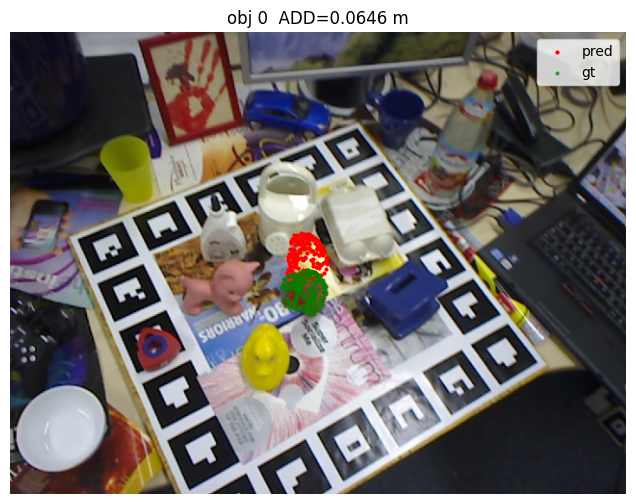

Saved viz: inference_viz/viz_122_obj0_add0.0837.png


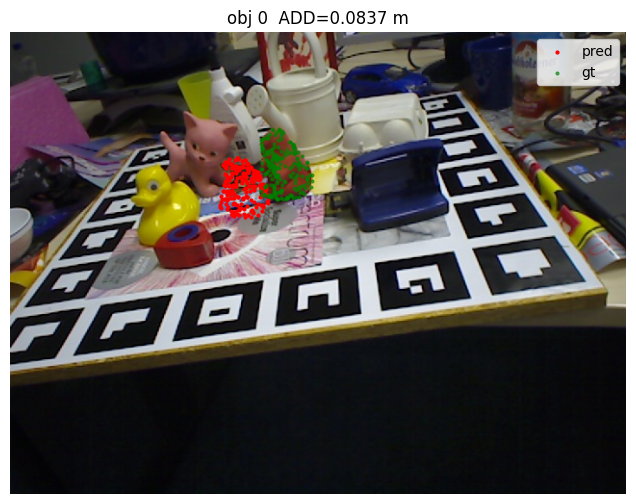

Saved viz: inference_viz/viz_8_obj0_add0.1536.png


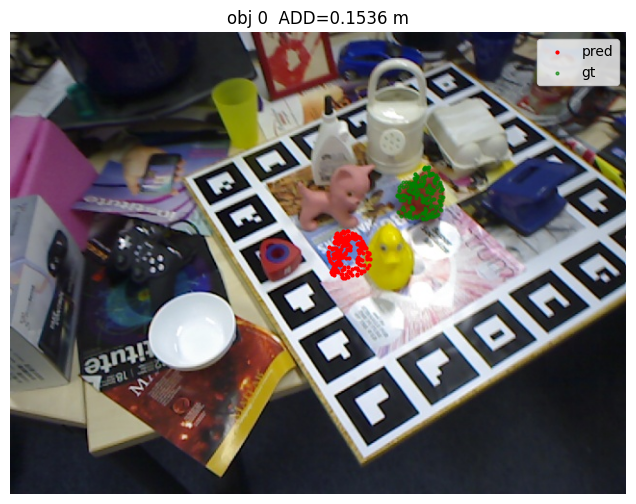

Saved viz: inference_viz/viz_31_obj0_add0.1129.png


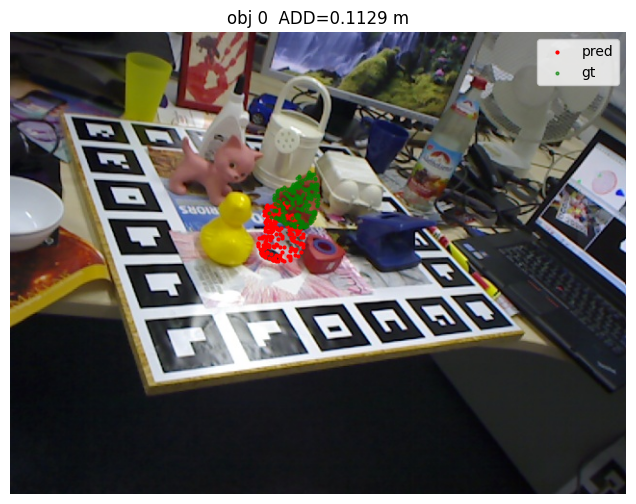

Saved viz: inference_viz/viz_35_obj0_add0.0750.png


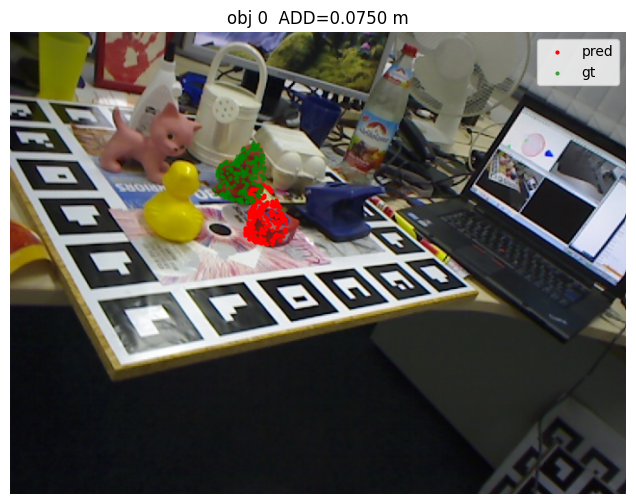

Saved viz: inference_viz/viz_116_obj0_add0.0367.png


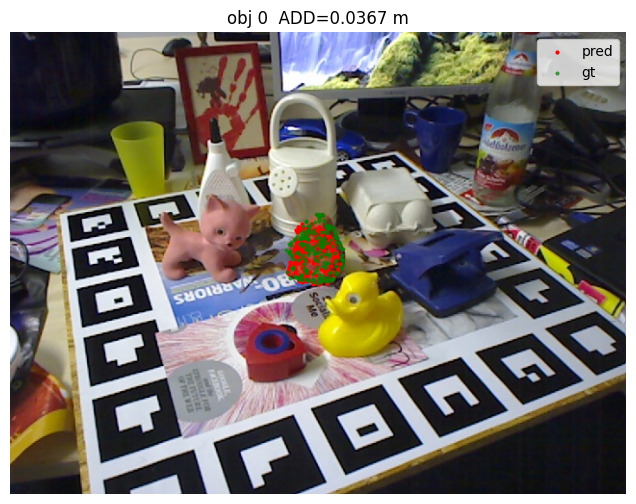

Saved viz: inference_viz/viz_90_obj0_add0.1438.png


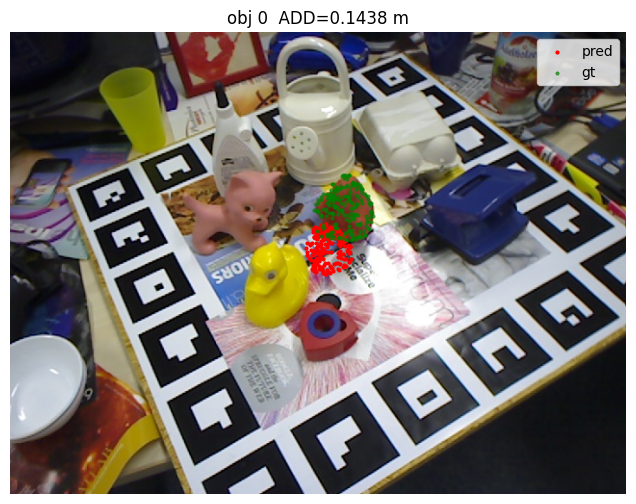

Saved viz: inference_viz/viz_66_obj0_add0.0804.png


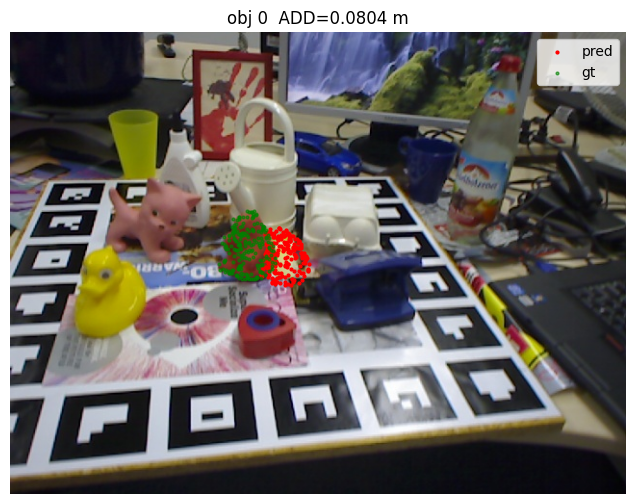

Done.


In [36]:
# INFERENCE: run on validation set, compute ADD/ADD-S, save CSV, visualize examples
import os, csv
import numpy as np
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_PATH = "./ckpts/formerpose_best.pt"   # change if you saved elsewhere
OUT_CSV = "./inference_results.csv"
n_visualize = 8  # number of validation samples to visualize (randomly chosen)
viz_out_dir = Path("./inference_viz")
viz_out_dir.mkdir(exist_ok=True, parents=True)

# ---------- helper: projection ----------
def project_model_points(model_pts, R, t, K):
    """
    Project model_pts (Mx3 numpy) given R (3x3) and t (3,) to pixel coords using intrinsics dict K.
    Returns (M,2) float array of pixel coordinates.
    """
    Pcam = (R @ model_pts.T).T + t[None,:]   # (M,3)
    # avoid divide-by-zero
    z = Pcam[:,2].copy()
    valid = z > 1e-6
    x = np.zeros_like(z); y = np.zeros_like(z)
    if np.any(valid):
        x[valid] = (Pcam[valid,0] * K['fx'] / Pcam[valid,2]) + K['cx']
        y[valid] = (Pcam[valid,1] * K['fy'] / Pcam[valid,2]) + K['cy']
    pts2d = np.stack([x,y], axis=1)
    return pts2d, valid

# ---------- load model checkpoint ----------
assert os.path.exists(CKPT_PATH), f"Checkpoint not found: {CKPT_PATH}"
ck = torch.load(CKPT_PATH, map_location=DEVICE)
net = FormerPose(img_ch=3, dim=CFG["hidden"], heads=4, scales=CFG["rgb_scales"], dropkey=CFG["dropkey_p"]).to(DEVICE)
net.load_state_dict(ck['model_state'])
net.eval()
print("Loaded checkpoint:", CKPT_PATH)

# ---------- recreate dataset and dataloader (use same split logic you used) ----------
DATA_PARENT = CFG["data_root"]
SINGLE_OBJ = "01"
ds = LinemodDataset(DATA_PARENT, img_size=CFG["img_size"], num_points=CFG["pc_n"], single_obj=SINGLE_OBJ)
N = len(ds)
nval = max(1, int(0.1 * N))
ntrain = N - nval
val_indices = list(range(ntrain, N))
val_ds = torch.utils.data.Subset(ds, val_indices)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"])

# ---------- load and map model bank ----------
original_bank = load_model_points_bank(CFG["model_points"])
mapped_bank, unused = build_mapped_model_bank(ds, original_bank)
print("Original model bank keys:", list(original_bank.keys())[:20])
print("Using mapped bank keys (dataset obj_ids):", list(mapped_bank.keys()))

# ---------- run inference over val set ----------
rows = []
all_adds = []
success_count = 0
measured = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="inference"):
        rgb = batch["rgb"].to(DEVICE)              # (B,3,H,W)
        pc = batch["pc"].to(DEVICE)                # (B,N,3)
        R_gt = batch["R_gt"].cpu().numpy()         # (B,3,3)
        t_gt = batch["t_gt"].cpu().numpy()         # (B,3)
        obj_ids = batch["obj_id"].cpu().numpy()    # (B,)
        objs = batch["object"]                     # list of strings (or tensors)

        rot6d, t_pred = net(rgb, pc)
        R_pred = rot6d_to_mat(rot6d).cpu().numpy()  # (B,3,3)
        t_pred = t_pred.cpu().numpy()               # (B,3)

        # for each sample in batch compute ADD/ADD-S if model available
        for i in range(rgb.size(0)):
            ds_idx = val_indices[ ( (i) + 0 ) ] if isinstance(val_ds, torch.utils.data.Subset) else None
            oid = int(obj_ids[i])
            model_pts = mapped_bank.get(oid, None)
            if model_pts is None:
                add = None
            else:
                # ensure numpy (Mx3)
                mp = model_pts
                # check symmetry: if you have sym info, set sym = (oid in sym_ids), else False
                sym = False
                if sym:
                    add = add_s_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i])
                else:
                    add = add_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i])
                all_adds.append(add)
                measured += 1
                if add < 0.1:
                    success_count += 1

            rows.append({
                "obj_id_dataset": int(oid),
                "obj_name": batch["object"][i],
                "add_m": float(add) if add is not None else None,
                "R_pred_flat": R_pred[i].reshape(-1).tolist(),
                "t_pred": t_pred[i].tolist(),
                "R_gt_flat": R_gt[i].reshape(-1).tolist(),
                "t_gt": t_gt[i].tolist()
            })

# ---------- summary ----------
if len(all_adds) == 0:
    print("No measured ADD values (model bank mismatch?).")
else:
    mean_add = float(np.mean(all_adds))
    sr = 100.0 * (success_count / float(len(all_adds)))
    print(f"Validation mean_ADD(S) = {mean_add:.6f} m   |   SR@0.1m = {sr:.2f}%   (measured {len(all_adds)} samples)")

# ---------- save CSV ----------
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print("Saved per-sample results to:", OUT_CSV)

# ---------- visualize random examples from the saved results ----------
# pick indices of rows with measured add
measured_indices = [i for i,r in enumerate(rows) if r['add_m'] is not None]
sel = np.random.choice(measured_indices, size=min(n_visualize, len(measured_indices)), replace=False) if measured_indices else []

for idx in sel:
    r = rows[idx]
    objid = r['obj_id_dataset']
    mp = mapped_bank[objid]    # (M,3)
    R_p = np.array(r['R_pred_flat']).reshape(3,3)
    t_p = np.array(r['t_pred'])
    R_g = np.array(r['R_gt_flat']).reshape(3,3)
    t_g = np.array(r['t_gt'])

    # determine sample's rgb path: we can use val_ds to fetch sample
    # val_ds is Subset of original ds; val_indices maps to dataset indices
    ds_idx = val_indices[idx % len(val_indices)]  # a safe approximate mapping for visualization
    sample = ds[ds_idx]  # NOTE: this uses dataset __getitem__ which returns tensors; we need the rgb path -> use s info
    # safer: get rgb path via dataset.samples recorded earlier:
    sample_info = ds.samples[ ds_idx ]
    rgb_path = sample_info['rgb']
    K = sample_info['intrinsics']

    img = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
    pts2d_p, valid_p = project_model_points(mp, R_p, t_p, K)
    pts2d_g, valid_g = project_model_points(mp, R_g, t_g, K)

    plt.figure(figsize=(8,6))
    plt.imshow(img); plt.axis('off')
    # plot predicted (red) and gt (green) model point projections (downsample for visibility)
    selp = np.arange(0, pts2d_p.shape[0], max(1, pts2d_p.shape[0]//200))
    plt.scatter(pts2d_p[selp,0], pts2d_p[selp,1], s=4, c='r', label='pred')
    plt.scatter(pts2d_g[selp,0], pts2d_g[selp,1], s=4, c='g', label='gt', alpha=0.6)
    plt.title(f"obj {objid}  ADD={r['add_m']:.4f} m")
    plt.legend()
    outp = viz_out_dir / f"viz_{idx}_obj{objid}_add{r['add_m']:.4f}.png"
    plt.savefig(outp, bbox_inches='tight', dpi=150)
    print("Saved viz:", outp)
    plt.show()

print("Done.")


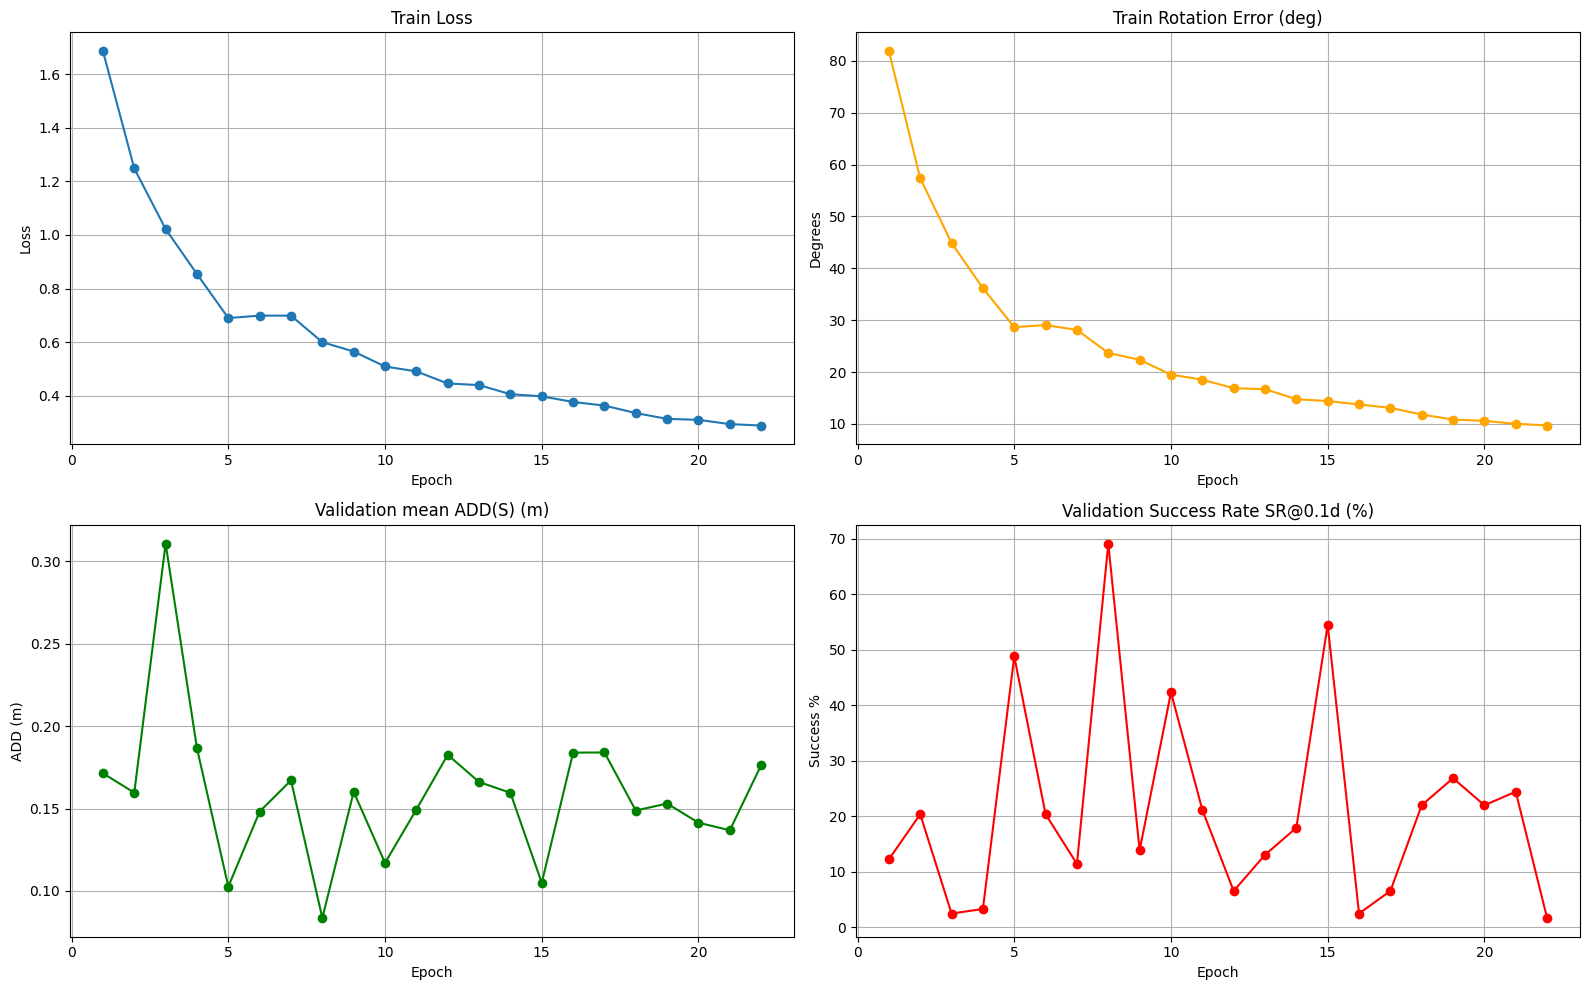

In [37]:
import re
import matplotlib.pyplot as plt

# ---- Paste your entire log text here ----
log_text = """
[001/030] train_loss=1.6866 | train_rot_deg=81.90 | train_tL1=0.0825  ||  val_OBJ01_mean_ADD(S)=0.171407 | val_OBJ01_SR@0.1d=12.20%
[002/030] train_loss=1.2483 | train_rot_deg=57.36 | train_tL1=0.0801  ||  val_OBJ01_mean_ADD(S)=0.159660 | val_OBJ01_SR@0.1d=20.33%
[003/030] train_loss=1.0220 | train_rot_deg=44.89 | train_tL1=0.0778  ||  val_OBJ01_mean_ADD(S)=0.310832 | val_OBJ01_SR@0.1d=2.44%
[004/030] train_loss=0.8540 | train_rot_deg=36.18 | train_tL1=0.0727  ||  val_OBJ01_mean_ADD(S)=0.186615 | val_OBJ01_SR@0.1d=3.25%
[005/030] train_loss=0.6896 | train_rot_deg=28.66 | train_tL1=0.0620  ||  val_OBJ01_mean_ADD(S)=0.102588 | val_OBJ01_SR@0.1d=48.78%
[006/030] train_loss=0.6988 | train_rot_deg=29.05 | train_tL1=0.0631  ||  val_OBJ01_mean_ADD(S)=0.148188 | val_OBJ01_SR@0.1d=20.33%
[007/030] train_loss=0.6986 | train_rot_deg=28.13 | train_tL1=0.0679  ||  val_OBJ01_mean_ADD(S)=0.167102 | val_OBJ01_SR@0.1d=11.38%
[008/030] train_loss=0.5997 | train_rot_deg=23.69 | train_tL1=0.0612  ||  val_OBJ01_mean_ADD(S)=0.083591 | val_OBJ01_SR@0.1d=69.11%
[009/030] train_loss=0.5647 | train_rot_deg=22.36 | train_tL1=0.0574  ||  val_OBJ01_mean_ADD(S)=0.160176 | val_OBJ01_SR@0.1d=13.82%
[010/030] train_loss=0.5088 | train_rot_deg=19.50 | train_tL1=0.0556  ||  val_OBJ01_mean_ADD(S)=0.117020 | val_OBJ01_SR@0.1d=42.28%
[011/030] train_loss=0.4905 | train_rot_deg=18.52 | train_tL1=0.0549  ||  val_OBJ01_mean_ADD(S)=0.149416 | val_OBJ01_SR@0.1d=21.14%
[012/030] train_loss=0.4454 | train_rot_deg=16.88 | train_tL1=0.0496  ||  val_OBJ01_mean_ADD(S)=0.182636 | val_OBJ01_SR@0.1d=6.50%
[013/030] train_loss=0.4394 | train_rot_deg=16.70 | train_tL1=0.0487  ||  val_OBJ01_mean_ADD(S)=0.166136 | val_OBJ01_SR@0.1d=13.01%
[014/030] train_loss=0.4053 | train_rot_deg=14.76 | train_tL1=0.0484  ||  val_OBJ01_mean_ADD(S)=0.159569 | val_OBJ01_SR@0.1d=17.89%
[015/030] train_loss=0.3975 | train_rot_deg=14.40 | train_tL1=0.0482  ||  val_OBJ01_mean_ADD(S)=0.104877 | val_OBJ01_SR@0.1d=54.47%
[016/030] train_loss=0.3763 | train_rot_deg=13.75 | train_tL1=0.0447  ||  val_OBJ01_mean_ADD(S)=0.183951 | val_OBJ01_SR@0.1d=2.44%
[017/030] train_loss=0.3629 | train_rot_deg=13.09 | train_tL1=0.0441  ||  val_OBJ01_mean_ADD(S)=0.184058 | val_OBJ01_SR@0.1d=6.50%
[018/030] train_loss=0.3349 | train_rot_deg=11.80 | train_tL1=0.0423  ||  val_OBJ01_mean_ADD(S)=0.148818 | val_OBJ01_SR@0.1d=21.95%
[019/030] train_loss=0.3133 | train_rot_deg=10.84 | train_tL1=0.0410  ||  val_OBJ01_mean_ADD(S)=0.153053 | val_OBJ01_SR@0.1d=26.83%
[020/030] train_loss=0.3097 | train_rot_deg=10.59 | train_tL1=0.0413  ||  val_OBJ01_mean_ADD(S)=0.141429 | val_OBJ01_SR@0.1d=21.95%
[021/030] train_loss=0.2936 | train_rot_deg=10.02 | train_tL1=0.0393  ||  val_OBJ01_mean_ADD(S)=0.136816 | val_OBJ01_SR@0.1d=24.39%
[022/030] train_loss=0.2885 | train_rot_deg=9.69 | train_tL1=0.0392  ||  val_OBJ01_mean_ADD(S)=0.176347 | val_OBJ01_SR@0.1d=1.63%
"""

# ---------- Parsing ----------
epochs = []
train_loss = []
train_rot = []
train_t = []
val_add = []
val_sr = []

pattern = r"\[(\d+)/\d+\] train_loss=([\d.]+) \| train_rot_deg=([\d.]+) \| train_tL1=([\d.]+)\s+\|\|  val_OBJ01_mean_ADD\(S\)=([\d.]+) \| val_OBJ01_SR@0\.1d=([\d.]+)%"

for line in log_text.strip().split("\n"):
    m = re.search(pattern, line)
    if m:
        ep = int(m.group(1))
        epochs.append(ep)
        train_loss.append(float(m.group(2)))
        train_rot.append(float(m.group(3)))
        train_t.append(float(m.group(4)))
        val_add.append(float(m.group(5)))
        val_sr.append(float(m.group(6)))

# ---------- Plotting ----------
plt.figure(figsize=(16,10))

# Train Loss
plt.subplot(2,2,1)
plt.plot(epochs, train_loss, marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Train rotation error
plt.subplot(2,2,2)
plt.plot(epochs, train_rot, marker='o', color='orange')
plt.title("Train Rotation Error (deg)")
plt.xlabel("Epoch")
plt.ylabel("Degrees")
plt.grid(True)

# Validation ADD(S)
plt.subplot(2,2,3)
plt.plot(epochs, val_add, marker='o', color='green')
plt.title("Validation mean ADD(S) (m)")
plt.xlabel("Epoch")
plt.ylabel("ADD (m)")
plt.grid(True)

# Success Rate @ 0.1d
plt.subplot(2,2,4)
plt.plot(epochs, val_sr, marker='o', color='red')
plt.title("Validation Success Rate SR@0.1d (%)")
plt.xlabel("Epoch")
plt.ylabel("Success %")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 👉 UPDATE THIS
CSV_PATH = "/content/inference_results.csv"   # <-- put correct path here

# Load CSV
df = pd.read_csv(CSV_PATH)

# Filter valid rows (non-null ADD)
valid = df[df["add_m"].notnull()].reset_index(drop=True)

# --------------------------------------------
# 1️⃣ Plot ADD per sample
# --------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(valid["idx"], valid["add_m"], marker="o", linestyle="-")
plt.title("ADD Error per Sample")
plt.xlabel("Sample Index")
plt.ylabel("ADD (meters)")
plt.grid(True)
plt.show()

# --------------------------------------------
# 2️⃣ Histogram of ADD values
# --------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(valid["add_m"], bins=30)
plt.title("Distribution of ADD Errors")
plt.xlabel("ADD (meters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# --------------------------------------------
# 3️⃣ Success Rate per sample (ADD < 0.1d)
# --------------------------------------------
success = (valid["add_m"] < valid["diam"] * 0.1).astype(int)

plt.figure(figsize=(10,5))
plt.plot(valid["idx"], success, marker="s")
plt.title("Success per Sample (ADD < 0.1 × diameter)")
plt.xlabel("Sample Index")
plt.ylabel("Success (0 or 1)")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.show()

# --------------------------------------------
# 4️⃣ Print overall success rate
# --------------------------------------------
SR = 100 * success.mean()
print(f"Overall Success Rate (SR@0.1d): {SR:.2f}%")
